CODE TO EVALUATE THE PERFORMANCES OF A THREE LAYERS PET IMAGE DENOISING U-NET

In [1]:
import numpy as np 
import odl 
import odlpet 
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim 
import torchvision
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt 
from odlpet.scanner.scanner import Scanner 
from odlpet.scanner.compression import Compression
from odl.contrib.torch import OperatorAsModule 
import time 
from odl.contrib import fom
import warnings
import GPUtil
from torch.utils.data.dataset import Dataset, TensorDataset
import nibabel

warnings.filterwarnings('ignore')
GPUtil.showUtilization()
torch.manual_seed(123)
torch.cuda.set_device(0)
torch.cuda.empty_cache()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 13% | 73% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
| ID | GPU | MEM |
------------------
|  0 | 13% | 73% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |


In [2]:
# PROJECTOR DEFINITION

scanner = Scanner() 
scanner.num_rings = 1
compression = Compression(scanner) 
compression.max_num_segments = 0 
compression.num_of_views = 180 
compression.num_non_arccor_bins = 147 
compression.data_arc_corrected = True
pet_projector = compression.get_projector(restrict_to_cylindrical_FOV=False)
pet_projector_adj=pet_projector.adjoint
pet_projector.range
pet_projector.domain 
fwd_op_mod=OperatorAsModule(pet_projector)
fwd_op_adj_mod = OperatorAsModule(pet_projector_adj)
transformations = transforms.Compose([transforms.ToTensor()]) 

# DEFINITION OF FUNCTION NEEDED TO GENERATE THE TRAINING SET

def generate_ellipsoids_2d(space,num=np.random.poisson(20),diag=100):

    max_axis=diag**2 
    surround=odl.uniform_discr([0, 0], [int(np.ceil(np.sqrt(max_axis))),int(np.ceil(np.sqrt(max_axis)))],[int(np.ceil(np.sqrt(max_axis))), int(np.ceil(np.sqrt(max_axis)))], dtype='float32') 
    elipse_image=np.zeros((space.shape[1],space.shape[2]))

    for i in range(num):
        value=np.random.rand() 
        angle=np.random.rand()*2*np.pi 

        if np.sqrt(max_axis)>np.max(pet_projector.domain.shape): 
            x_center=2*np.random.rand()-1 
            y_center=2*np.random.rand()-1 
            axis1=np.random.exponential(scale=.5) 
            axis2=np.random.exponential(scale=.5) 

            if axis2>axis1:
                while axis2>axis1:
                    axis2=np.random.rand()

            elipse=[[value,axis1, axis2,x_center, y_center,angle]]

            el=odl.phantom.geometric.ellipsoid_phantom(surround, elipse).asarray()

            s=np.sum(el[int(np.sqrt(max_axis/2))-int(pet_projector.domain.shape[1]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[1]/2),int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[2]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[2]/2)])
            if s>0: 
                elipse_image+=el[int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[1]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[1]/2)+1,int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[2]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[2]/2)+1]
        else:
            print('Please introduce a maximum value of the ellipse long axis larger than the size of the reconstruction space in both dimensions')
            break
        
    return elipse_image


def ellipse_batch(space, number_of_images,number_of_elipses): 
    
    images = np.zeros((number_of_images,space.shape[1],space.shape[2])) 
        
    for i in range(number_of_images):
        image = generate_ellipsoids_2d(space,number_of_elipses,200)
        images[i,:,:]=image
          
    return images 

numTest = 10 # CHANGE HERE TEST SET SIZE

class RandomEllipsoids(Dataset):
    def __init__(self,space,num_ellipsoids,diag,train=True,transforms=None):
        """
        Args:
            space: image space where to obtain the dataset of ellipsoid images
            num: number of random ellipsoids
            diag: size of surrounding space used to compute ellipsoids outside the center of the FOV
            num_imag: number of images generated
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.space = pet_projector.domain 
        self.num_ellipsoids= np.random.poisson(15) 
        self.diag = diag 
        self.train=train 
        self.transforms = transformations 

    def __getitem__(self,index):
        data=torch.tensor(ellipse_batch(self.space,1,self.num_ellipsoids))
        
        return data

    def __len__(self):
        if self.train==True:
            return 0 
        else:
            return numTest 

def generate_data(images, operator, noise_level=1.):
    """Create noisy projection data from images.
    
    The data is generated according to ::
        
        data = Poisson(fwd_op(images)/10)
        
    where ``noise`` is standard white noise.
    
    Parameters
    ----------
    images : `Tensor`, shape ``(B, C, 28, 28)``
        Input images for the data generation.
        
    Returns
    -------
    data : `Tensor`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123) 
    data = operator(images) 
    noisy_data = torch.tensor(np.random.poisson(data.cpu()/noise_level)*noise_level) 
    
    return noisy_data

if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()]) 
    random_ellipsoids =         RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(15), diag=100, train=True, transforms=transformations)


# MLEM RECONSTRUCTION OPERATORS DEFINITIONS

class MLEM(odl.operator.Operator):
    def __init__(self, op, niter):
        super(MLEM, self).__init__(domain=pet_projector.range, range=pet_projector.domain, linear=True) 
        self.op = op 
        self.niter = niter 
    
    def _call(self, data):
        reco = self.range.one()
        odl.solvers.iterative.statistical.mlem(self.op, reco, data, niter=self.niter) 
        return reco

mlem_op_comp=MLEM(pet_projector,niter=10) # MLEM operator 10 iterations
mlem_op_comp_mod=OperatorAsModule(mlem_op_comp) 

mlem_op_net=MLEM(pet_projector,niter=1) # MLEM operator. 1 iteration
mlem_op_net_mod=OperatorAsModule(mlem_op_net) 


# FUNCTION TO COMPUTE PSNR

def peak_SNR(img,ground_truth):
    
    img=torch.tensor(img/np.amax(img.flatten()))
    ground_truth=torch.tensor(ground_truth/np.amax(ground_truth.flatten()))
    
    mse=nn.MSELoss() 
    return -10*np.log10(mse(img.float(),ground_truth.float())) 


In [3]:
# ARCHITECTURE DEFINITION

class Unet(nn.Module):
    
    def __init__(self):
        
        super(Unet,self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(32,32,3,stride = 1,padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True) 
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32,64,3,padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64,64,3,stride = 1,padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True)
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128,128,3,stride = 1,padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True)
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer4 = nn.Sequential(
                        nn.Conv2d(128,256,3,padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256,256,3,stride = 1,padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        
        )
        
        
        self.layerUP31 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True)
                        
        )
        
        self.layerUP32 = nn.Sequential(
                        nn.Conv2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128,128,3,1,1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True)
                        
        )
        
        self.layerUP41 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,2,0,0),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True)
        )
        
        self.layerUP42 = nn.Sequential(
                        nn.Conv2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64,64,3,1,1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True)
        )
        
        self.layerUP51 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,2,0,0),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True)
        )
        self.layerUP52 = nn.Sequential(
                        nn.Conv2d(64,32,3,1,1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(32,32,3,1,1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True)
        )
        
        self.layerUP61 = nn.Sequential(
                        nn.Conv2d(32,1,1,1,0),
                        nn.ReLU(inplace=True)
        )
        
          
    def forward(self,x):
        
        #print(x.shape)
        l1 = self.layer1(x)
        #print(l1.shape)
        l2 = self.layer2(self.pool1(l1))
        #print(l2.shape)
        l3 = self.layer3(self.pool2(l2))
        #print(l3.shape)

        mid = self.layer4(self.pool3(l3))
        #print(mid.shape)
        
        l3up = self.layerUP31(mid)
        l3up = torch.cat((l3up,l3),dim=1)
        l3up = self.layerUP32(l3up)
        #print(l3up.shape)
        l4up = self.layerUP41(l3up)
        l4up = torch.cat((l4up,l2),dim=1)
        l4up = self.layerUP42(l4up)
        #print(l4up.shape)
        l5up = self.layerUP51(l4up)
        l5up = torch.cat((l5up,l1),dim=1)
        l5up = self.layerUP52(l5up)
        #print(l5up.shape)
        out = self.layerUP61(l5up)
        #print(out.shape)
        
        return out


Unet = Unet().cuda()


In [4]:
# PARAMETERS LOADING

loss_test = nn.SmoothL1Loss() 

try:
    checkpoint = torch.load('Unet3Layers75k75VN.tar')
    Unet.load_state_dict(checkpoint['model_state_dict'])
    Unet.to("cuda")

    print("\n--------model restored--------\n")
except:
    print("\n--------model NOT restored--------\n")
    
GPUtil.showUtilization()



--------model restored--------

| ID | GPU | MEM |
------------------
|  0 |  3% | 77% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |


PERFORMANCES EVALUATION ON ELLIPSES IMAGES, THE PROCESS IS REPEATED numIter TIMES ON numTest IMAGES TO OBTAIN STATISTICAL SIGNIFICANCE 

Loss:  0.00333238882013  +-  0.00088155134725
PSNR:  27.3426  +-  0.227389
SSIM:  0.927470308808  +-  0.0135039242733
DPSNR:  5.51485  +-  1.04542
DSSIM:  0.345266613688  +-  0.0449762855816


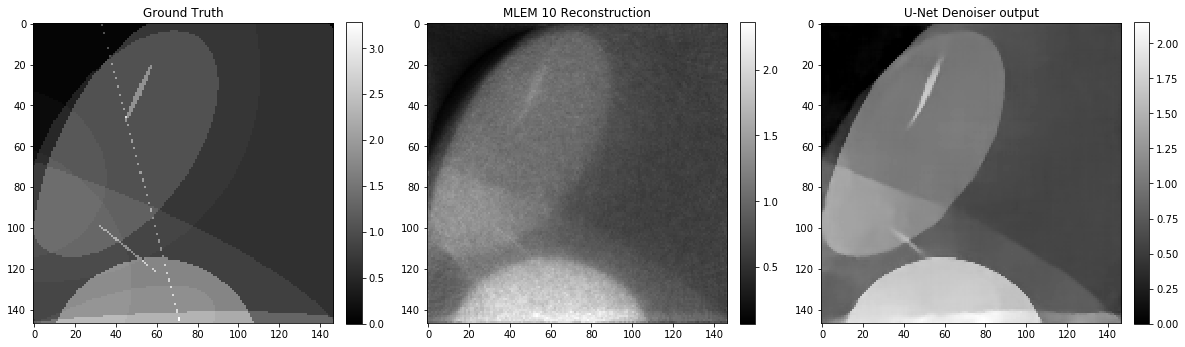

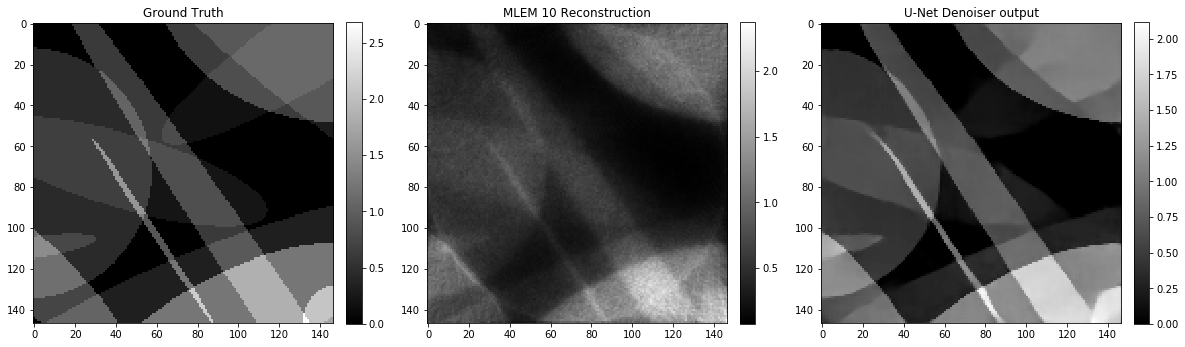

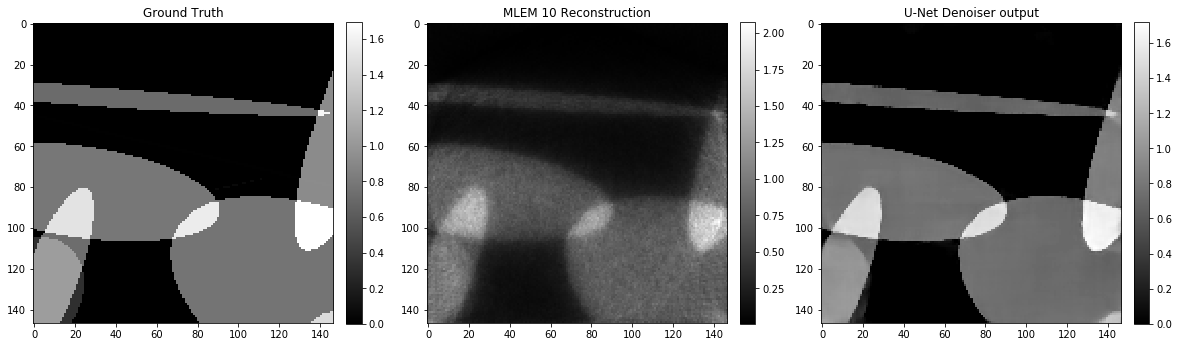

In [5]:
Unet.eval()

avg_losses = []
avg_PSNR = []
avg_SSIM = []
avg_DPSNR = []
avg_DSSIM = []

batch_size = 5
numIter = 3

for j in range(numIter):
    
    # TEST DATA GENERATION
    
    trafo = transforms.Compose([transforms.ToTensor(),])
    dset_test=RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(20), diag=200, train=False,transforms=trafo)
    test_loader = torch.utils.data.DataLoader(dset_test, numTest , shuffle=False)

    for i,images in enumerate(test_loader):
        if i == 1:
            break

    test_images = images 

    noise=np.random.uniform(1/10,1/3) 
    test_data = generate_data(test_images,fwd_op_mod,noise_level=noise) 
    reco = mlem_op_net_mod(test_data) 

    test_set = TensorDataset(test_images,reco)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size , shuffle=True) 

    # LOSS AND RESULTS COMPUTATION
    
    losses = []
    test_res_denoise = np.zeros(test_images.shape)

    for batch_idx,(test_im,recons) in enumerate(test_loader):

        loss = loss_test(Unet(recons.cuda().float()), test_im.cuda().float())
        losses.append(loss.item())

    loss_avg = np.mean(np.asarray(losses))
    
    avg_losses.append(loss_avg)

    
    for i in range(0,test_images.shape[0]):

        reco_results = reco[i:i+1,:,:,:]
        test_res = Unet((reco_results.cuda().float())).detach().cpu()
        test_res_denoise[i,:,:,:] = test_res

    # MLEM 10 RECONSTRUCTION    
        
    mlem_test_10=mlem_op_comp_mod(test_data) 
    
    # FIGURES OF MERIT COMPUTATION
    
    test_images_norm=np.copy(test_images.numpy().squeeze())
    mlem_10_norm=np.copy(mlem_test_10.numpy().squeeze())
    denoised_norm=np.copy(test_res_denoise.squeeze())

    index=[]
    for i in range(test_images.shape[0]):
        if np.amax(test_images_norm[i,:,:].flatten())!=0:
            index.append(i)

    mlem_ssim_list = []
    ellipses_ssim_list = []
    mlem_psnr_list = []
    ellipses_psnr_list = []
    for i in index: 
        mlem_ssim_list.append(fom.ssim(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
        ellipses_ssim_list.append(fom.ssim(denoised_norm[i,:,:],test_images_norm[i,:,:]))
        mlem_psnr_list.append(peak_SNR(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
        ellipses_psnr_list.append(peak_SNR(denoised_norm[i,:,:],test_images_norm[i,:,:]))

    mlem_ssim=np.mean(mlem_ssim_list) 
    ellipses_ssim=np.mean(ellipses_ssim_list) 

    mlem_psnr= np.mean(mlem_psnr_list) 
    ellipses_psnr=np.mean(ellipses_psnr_list)     
    avg_PSNR.append(ellipses_psnr)
    avg_SSIM.append(ellipses_ssim)
    avg_DPSNR.append(ellipses_psnr-mlem_psnr)
    avg_DSSIM.append(ellipses_ssim-mlem_ssim)
    
    # RESULT VISUALIZATION

    num = 0
    plt.figure(figsize=(20,20))

    plt.subplot(131)
    plt.imshow(test_images[num,0,:,:].cpu(),cmap='gray')
    plt.title('Ground Truth')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(132)
    plt.imshow(mlem_test_10[num,0,:,:].cpu(),cmap='gray')
    plt.title('MLEM 10 Reconstruction')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(133)
    plt.imshow(test_res_denoise[num,0,:,:],cmap='gray')
    plt.title('U-Net Denoiser output')
    plt.colorbar(fraction=0.046, pad=0.04)
    
print('Loss: ', np.mean(avg_losses),' +- ',np.std(avg_losses))
print('PSNR: ', np.mean(avg_PSNR),' +- ',np.std(avg_PSNR))
print('SSIM: ', np.mean(avg_SSIM),' +- ',np.std(avg_SSIM))
print('DPSNR: ', np.mean(avg_DPSNR),' +- ',np.std(avg_DPSNR))
print('DSSIM: ', np.mean(avg_DSSIM),' +- ',np.std(avg_DSSIM))




PERFORMANCES EVALUATION ON SHEPP-LOGAN PHANTOM

In [6]:
# SHEPP-LOGAN DATA GENERATION

rs=odl.uniform_discr([  0. , -21.9, -21.9], [  0.675,  22.2  ,  22.2  ], (147, 147, 147), dtype='float32')
SLP= odl.phantom.shepp_logan(rs,modified=True)

SLP_slices = np.zeros((147,1,147,147))

for i in range(147):
    SLP_slices[i,0,:,:] = SLP[:,:,i]

SLP_slices = torch.tensor(SLP_slices[30:107,0:1,:,:])


loganSin = torch.tensor(np.zeros((SLP_slices.shape[0],1,180,147)))

for i in range(SLP_slices.shape[0]):
    noise = np.random.uniform(1/10,1/3)
    loganSin[i,:,:,:] = generate_data(SLP_slices[i:i+1,:,:,:],fwd_op_mod,noise_level=noise) 
    
reco_logan=mlem_op_net_mod(loganSin)

# 10 ITERATIONS MLEM RECONSTRUCTION

mlem_test_10_logan=mlem_op_comp_mod(loganSin) 


In [7]:
# LOSS AND RESULTS COMPUTATION

Unet.eval() 

test_set = TensorDataset(torch.tensor(SLP_slices),reco_logan)
test_loader = torch.utils.data.DataLoader(test_set,batch_size , shuffle=False) 

losses = []
for batch_idx,(test_im,recons) in enumerate(test_loader):
        
    loss = loss_test(Unet(recons.cuda().float()), test_im.cuda().float())
    losses.append(loss.item())

loss_avg = np.mean(np.asarray(losses))
    
print('\nTest set: Average loss: {:.6f}'.format(loss_avg))

test_res_denoise_logan = np.zeros(reco_logan.shape)

for i in range(0,reco_logan.shape[0]):

    reco_logans = reco_logan[i:i+1,:,:,:]
    test_res_logan = Unet((reco_logans.cuda().float())).detach().cpu() 
    test_res_denoise_logan[i,:,:,:]=test_res_logan
    


Test set: Average loss: 0.000552


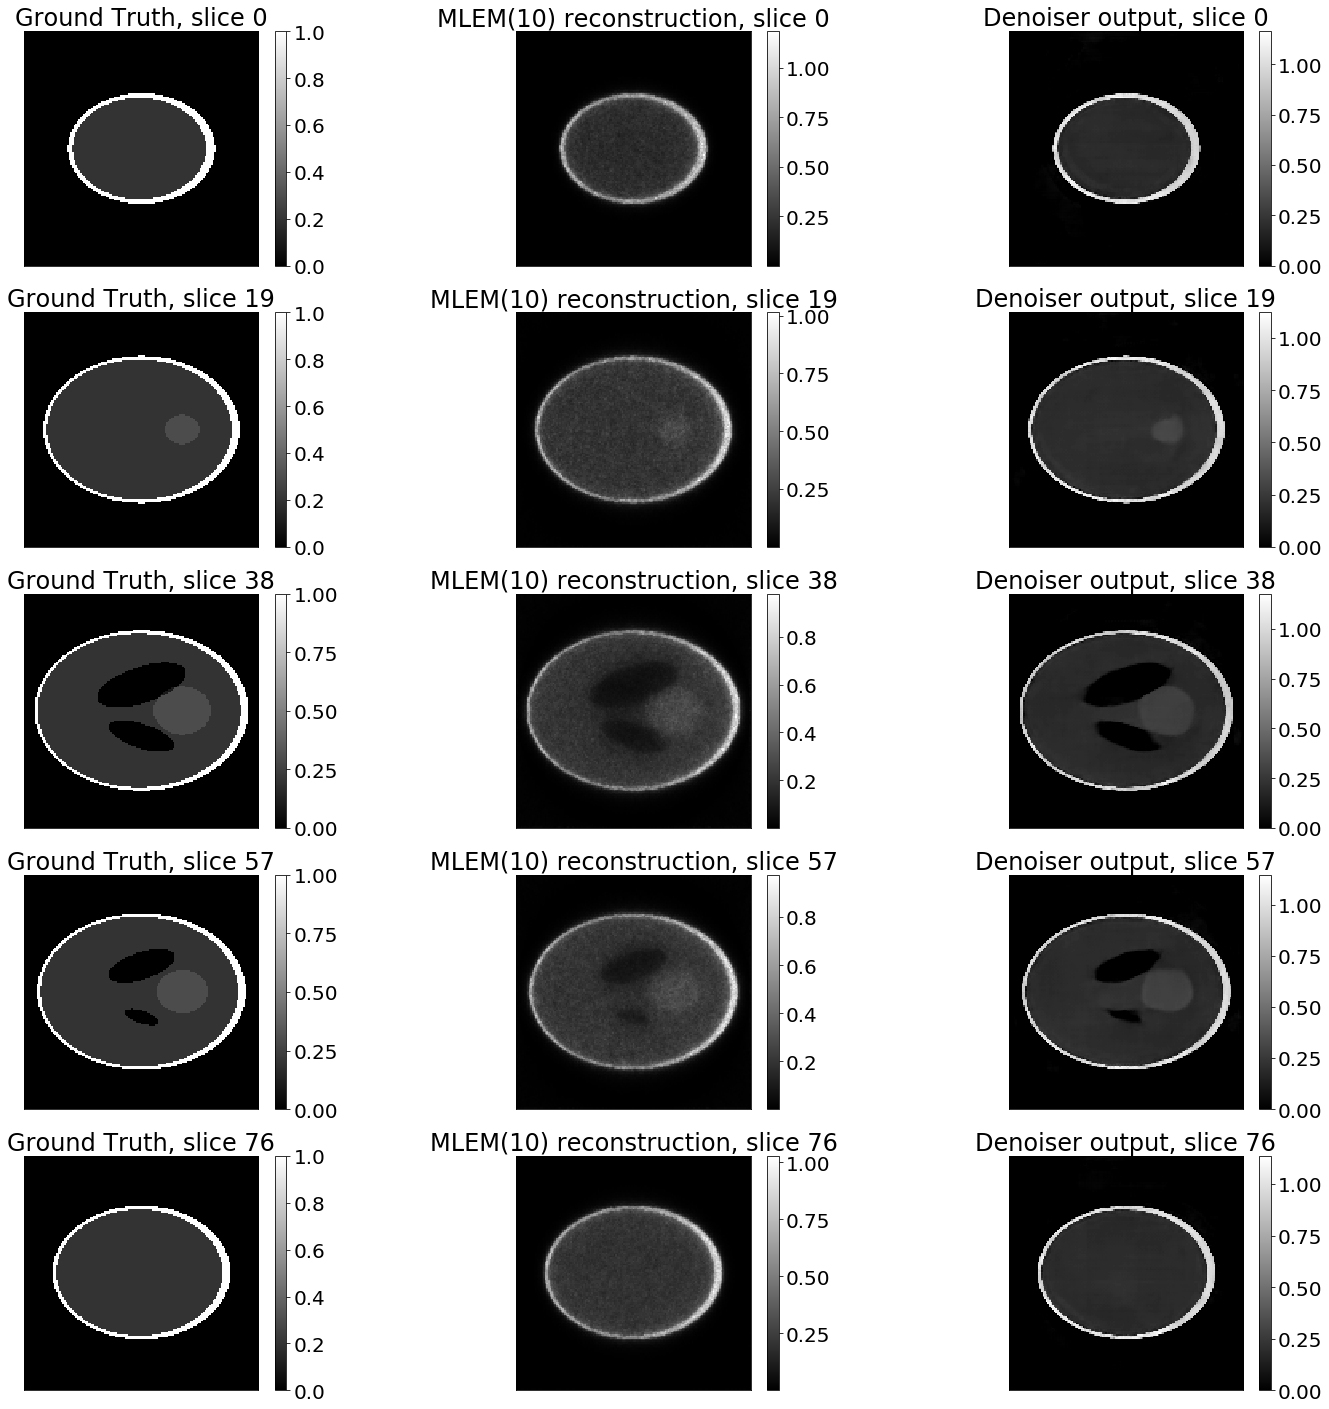

In [8]:
# RESULTS VISUALIZATION

num_print = 5 # SELECT HOW MANY SLICES TO PRINT

plt.figure(figsize=(25,25))
k = 1
plt.rcParams.update({'font.size': 20})

for i in np.floor(np.linspace(0,reco_logan.shape[0]-1,num_print)).astype(int):
    
    plt.subplot(num_print,3,k)
    plt.imshow(SLP_slices[i,0,:,:],cmap='gray')
    plt.title('Ground Truth, slice '+str(i))
    plt.colorbar(fraction=0.046, pad=0.04)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)

    plt.subplot(num_print,3,k+1)
    plt.imshow(mlem_test_10_logan[i,0,:,:].cpu(),cmap='gray')
    plt.title('MLEM(10) reconstruction, slice '+str(i))
    plt.colorbar(fraction=0.046, pad=0.04)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)

    plt.subplot(num_print,3,k+2)
    plt.imshow(test_res_denoise_logan[i,0,:,:],cmap='gray')
    plt.title('Denoiser output, slice '+str(i))
    plt.colorbar(fraction=0.046, pad=0.04)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    
    k = k+3
    

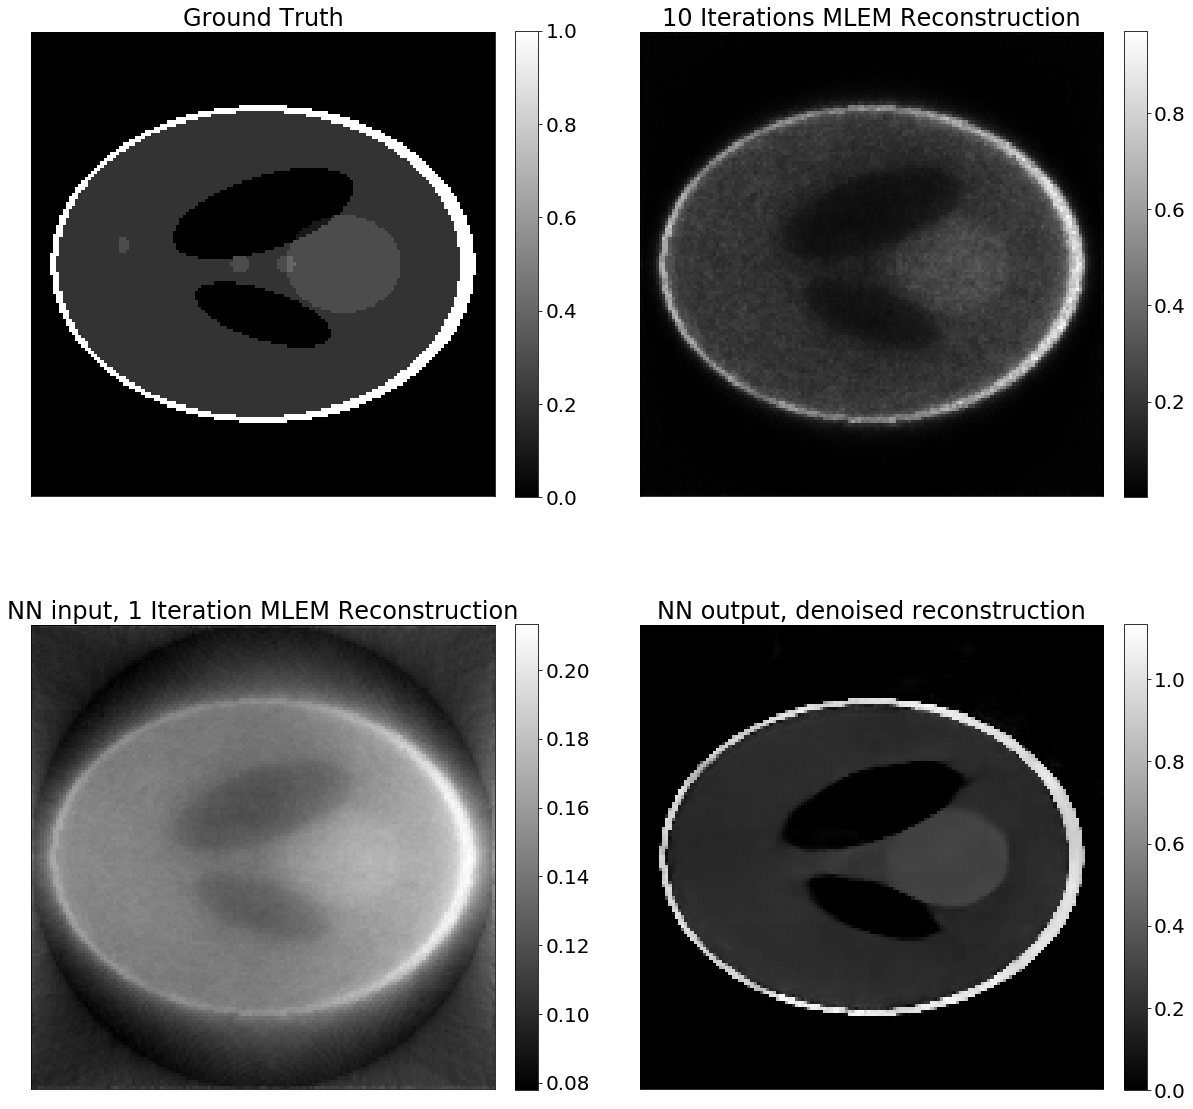

In [9]:
# SHOW GT, 10mlem, U-NET INPUT AND U-NET OUTPUT IN ONE FIGURE

num = 41 # SELECT SLICE HERE
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(SLP_slices[num,0,:,:],cmap='gray',)
plt.title('Ground Truth')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(222)
plt.imshow(mlem_test_10_logan[num,0,:,:],cmap='gray')
plt.title('10 Iterations MLEM Reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(223)
plt.imshow(reco_logan[num,0,:,:],cmap='gray')
plt.title('NN input, 1 Iteration MLEM Reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(224)
plt.imshow(test_res_denoise_logan[num,0,:,:],cmap='gray')
plt.title('NN output, denoised reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)


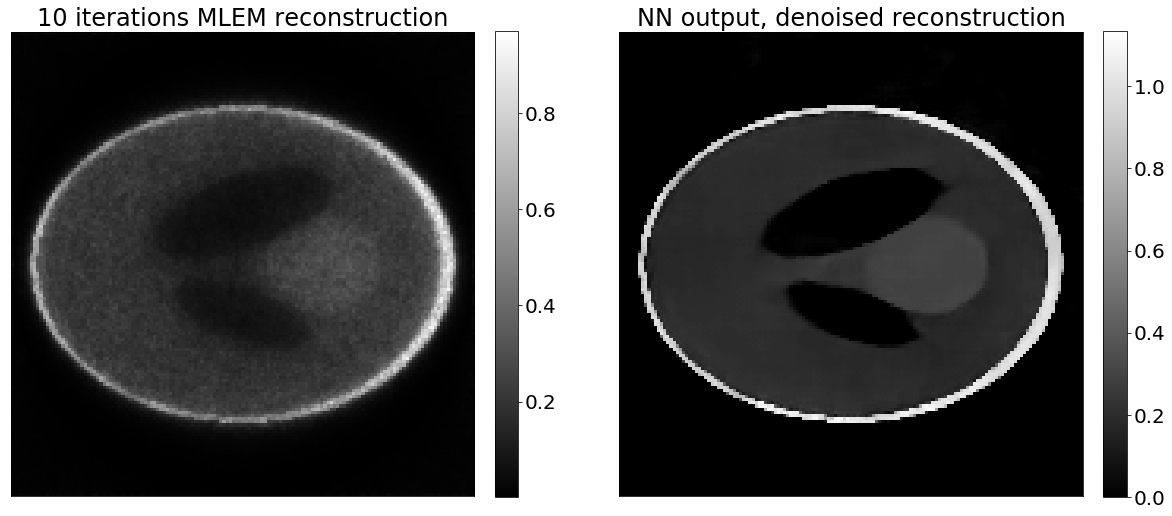

In [10]:
# COMPARISON MLEM 10 RECONSTRUCTION U-NET DENOISER RESULT

num = 41 # SELECT SLICE HERE
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(mlem_test_10_logan[num,0,:,:],cmap='gray')
plt.title('10 iterations MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(122)
plt.imshow(test_res_denoise_logan[num,0,:,:],cmap='gray')
plt.title('NN output, denoised reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)


In [11]:
# EVALUATE SHEPP LOGAN RESULTS WITH FIGURES OF MERIT

test_images_norm=np.copy(SLP_slices.squeeze())
mlem_10_norm=np.copy(mlem_test_10_logan.numpy().squeeze())
denoised_norm=np.copy(test_res_denoise_logan.squeeze())

index=[]
for i in range(test_images_norm.shape[0]):
    if np.amax(test_images_norm[i,:,:].flatten())!=0:
        index.append(i)
        
mlem_ssim_list = []
ellipses_ssim_list = []
mlem_psnr_list = []
ellipses_psnr_list = []
for i in index: 
    mlem_ssim_list.append(fom.ssim(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_ssim_list.append(fom.ssim(denoised_norm[i,:,:],test_images_norm[i,:,:]))
    mlem_psnr_list.append(peak_SNR(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_psnr_list.append(peak_SNR(denoised_norm[i,:,:],test_images_norm[i,:,:]))

mlem_ssim=np.mean(mlem_ssim_list)
ellipses_ssim=np.mean(ellipses_ssim_list)

mlem_psnr= np.mean(mlem_psnr_list) 
ellipses_psnr=np.mean(ellipses_psnr_list)

print('\nDSSIM: {}'.format(ellipses_ssim-mlem_ssim))
print('\nAverage SSIM for denoised images with ellipsoids network: {}\n'.format(ellipses_ssim))

print('\nDPSNR: {}'.format(ellipses_psnr-mlem_psnr))
print('\nAverage PSNR for denoised images with ellipsoids network: {}\n'.format(ellipses_psnr))


DSSIM: 0.25684343510982865

Average SSIM for denoised images with ellipsoids network: 0.9590775325421262


DPSNR: 5.95789909362793

Average PSNR for denoised images with ellipsoids network: 26.349645614624023



PERFORMANCES EVALUATION ON miniPET DATA

In [12]:
# mini-PET DATA SPACE DEFINITION

scanner2 = Scanner() 
scanner2.num_rings = 35 
compression2 = Compression(scanner2) 
compression2.max_num_segments = 0 
compression2.num_of_views = 180 
compression2.num_non_arccor_bins = 147 
compression2.data_arc_corrected = True
pet_projector2 = compression2.get_projector(restrict_to_cylindrical_FOV=False) 
pet_projector_adj2=pet_projector2.adjoint

In [13]:
# FUNCTION TO SPLIT A 3D VOLUME INTO 35 SINGLE SLICES

def volumeSplitter(inputTensor):

    
    volumes = inputTensor.numpy()
    newVolumes = np.zeros((volumes.shape[2],1,volumes.shape[3],volumes.shape[4]))

    i = 0
    while i < volumes.shape[0]:
            
        k = 0
        while  k < volumes.shape[2]:
            newVolumes[k+i*volumes.shape[2],0,:,:] = volumes[i,0,k,:,:]
            k = k+1
                
        i = i+1
            
    newVolumes = torch.tensor(newVolumes)
    return newVolumes

In [14]:
# LOAD miniPET DATA

real=nibabel.load('IQphantom.sino.mnc') 
real_data = real.get_data() 
real_data_ = np.transpose(real_data, (0,2,1)) 
data = pet_projector2.range.element(real_data_) 
data[data.asarray() < 0] = 0 
a = np.zeros((1,1,data.shape[0],data.shape[1],data.shape[2]))
a[0,0,:,:,:]=data
data=torch.tensor(a)
data=volumeSplitter(data)
reco_data10 = mlem_op_comp_mod(data)
reco_data = mlem_op_net_mod(data)

In [16]:
test_res_denoise_data = np.zeros(reco_data.shape)

for i in range(0,reco_data.shape[0]):

    reco_datas = reco_data[i:i+1,:,:,:]
    test_res_data = Unet((reco_datas.cuda().float())).detach().cpu() 
    test_res_denoise_data[i,:,:,:]=test_res_data

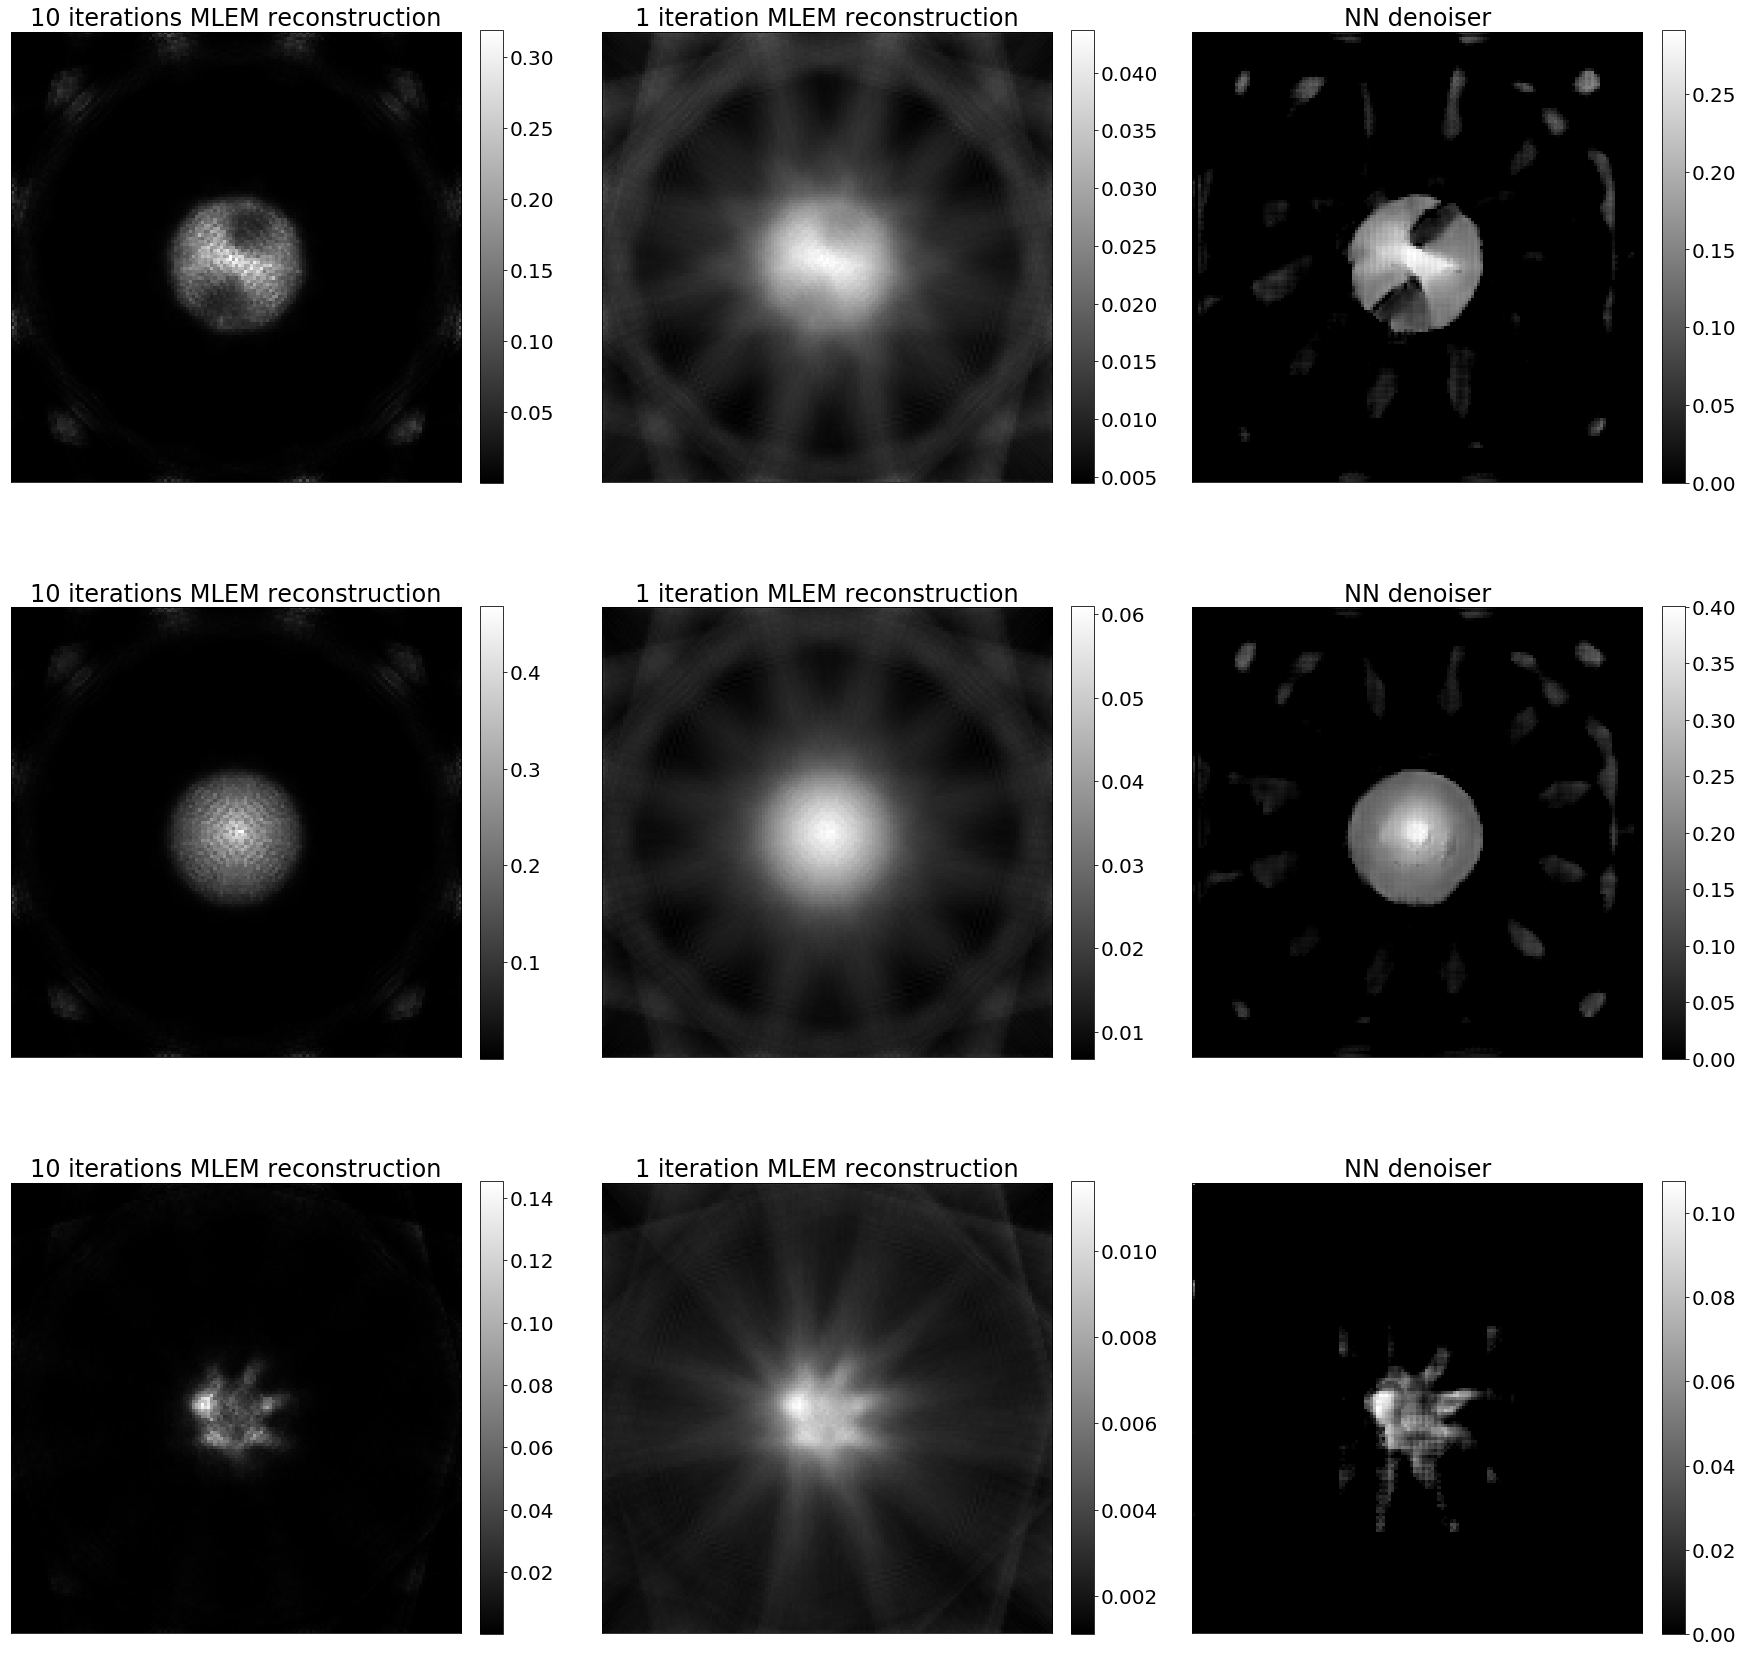

In [17]:
# RESULT VISUALIZATION

num = 6
plt.figure(figsize=(30,30))

plt.subplot(331)
plt.imshow(reco_data10[num,0,:,:],cmap='gray')
plt.title('10 iterations MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(332)
plt.imshow(reco_data[num,0,:,:],cmap='gray')
plt.title('1 iteration MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(333)
plt.imshow(test_res_denoise_data[num,0,:,:],cmap='gray')
plt.title('NN denoiser')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

num = 17

plt.subplot(334)
plt.imshow(reco_data10[num,0,:,:],cmap='gray')
plt.title('10 iterations MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(335)
plt.imshow(reco_data[num,0,:,:],cmap='gray')
plt.title('1 iteration MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(336)
plt.imshow(test_res_denoise_data[num,0,:,:],cmap='gray')
plt.title('NN denoiser')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

num = 24

plt.subplot(337)
plt.imshow(reco_data10[num,0,:,:],cmap='gray')
plt.title('10 iterations MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(338)
plt.imshow(reco_data[num,0,:,:],cmap='gray')
plt.title('1 iteration MLEM reconstruction')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

plt.subplot(339)
plt.imshow(test_res_denoise_data[num,0,:,:],cmap='gray')
plt.title('NN denoiser')
plt.colorbar(fraction=0.046, pad=0.04)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
